In [1]:
import numpy as np
import pandas as pd

from numpy import mean, std, cov, sqrt, log, sum
from numpy.random import seed

from datetime import date, timedelta, datetime

from scipy.stats import pearsonr,spearmanr, boxcox
from scipy import stats

from random import sample

from apyori import apriori
from mlxtend.frequent_patterns import apriori

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import matplotlib.style as style

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

from statsmodels.formula.api import ols


import warnings
warnings.filterwarnings('ignore')

import scripts as src

from IPython.display import HTML, display

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rcParams['figure.figsize'] = (6, 3)

rand_state=1000

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import catboost as ctb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

import tensorflow.keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

## Import Data

In [3]:
## import data
raw_beneficiary=pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv')
raw_inpatient=pd.read_csv('data/Train_Inpatientdata-1542865627584.csv')
raw_outpatient=pd.read_csv('data/Train_Outpatientdata-1542865627584.csv')
raw_train=pd.read_csv('data/Train-1542865627584.csv')

## merge data
inpatient_beneficiary=pd.merge(raw_inpatient,raw_beneficiary,on='BeneID')
outpatient_beneficiary=pd.merge(raw_outpatient,raw_beneficiary,on='BeneID')

outpatient_beneficiary['Category']='Outpatient'
inpatient_beneficiary['Category']='Inpatient'

raw=pd.concat([outpatient_beneficiary, inpatient_beneficiary], axis = 0)
raw=pd.merge(raw,raw_train,on='Provider', how='left')

In [4]:
y = raw['PotentialFraud']
X = raw.drop(['PotentialFraud'], axis=1) # becareful inplace= False

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)
print('train data size:',df_train.shape,
     '\ntrain data size:',df_test.shape,
     '\ntotal:',len(df_train)+len(df_test))

train data size: (446568, 56) 
train data size: (111643, 56) 
total: 558211


## Feature Engineering

In [5]:
def preprocessing(df_raw):
    ## Ages
    df_raw[['ClaimStartDt', 'ClaimEndDt', 'DischargeDt', 'AdmissionDt', 'DOB', 'DOD']]= \
            df_raw[['ClaimStartDt', 'ClaimEndDt', 'DischargeDt', 'AdmissionDt', 'DOB', 'DOD']].apply(pd.to_datetime, format='%Y-%m-%d')

    df_raw['IsDead']=np.where(df_raw['DOD'].isna(), 'No', 'Yes')

    df_raw['AdmissionDt']=df_raw['AdmissionDt'].fillna(df_raw['ClaimStartDt'])

    df_raw['Age']=round((pd.to_datetime(df_raw['AdmissionDt'])-pd.to_datetime(df_raw['DOB'])).dt.total_seconds() / (24 * 60 * 60 * 365),1)

    df_raw['Age_group'] = pd.cut(df_raw['Age'],
                         bins=[0,25, 35, 45,55,65,75,85,90,100,120],
                         labels=['<25','25-35','35-45','45-55','55-65','65-75','75-85','85-90','95-100','>100'],
                         right=False)

    df=df_raw[['Provider','Age']].groupby(['Provider'])['Age'].mean().reset_index().rename(columns={'Age':'AverageAge'})
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    ## RenalDiseaseIndicator
    df_raw['RenalDiseaseIndicator']=np.where((df_raw['RenalDiseaseIndicator'])=='0', 0, 1)

    ## Gender 
    df_raw = df_raw.replace({'Gender': 2}, 'Female')
    df_raw = df_raw.replace({'Gender': 1}, 'Male')

    ## Chronic Features
    df_raw = df_raw.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                       'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                       'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                       'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

    chronic_list=['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                  'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                  'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                  'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke','RenalDiseaseIndicator']

    # add mean of chronic condition numbers in claims by providers
    df_raw['Chronic_number']=df_raw[chronic_list].sum(axis=1)

    df=df_raw[chronic_list+['Provider','Chronic_number']].groupby(['Provider']).mean().reset_index()

    df_raw.drop(chronic_list+['Chronic_number'], axis=1, inplace=True)
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    ## Treatment Duration
    df_raw['ClaimStartWeek']=df_raw['ClaimStartDt'].dt.week
    df_raw['ClaimStartYear']=df_raw['ClaimStartDt'].dt.year

    df_raw['DischargeDt']=df_raw['DischargeDt'].fillna(df_raw['AdmissionDt'])

    df_raw['TreatmentDuration']=(df_raw['DischargeDt']-df_raw['AdmissionDt']).astype('timedelta64[D]').astype('int', errors='ignore')
    
    ## Diagnosis and Procedure codes
    # fill in missing values
    df_raw.dropna(how='all', inplace=True)

    codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
           'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
           'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
           'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
           'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
           'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']

    amountlist=['DeductibleAmtPaid']

    for col in codelist:
        df_raw[col]=df_raw[col].fillna('0')

    for col in amountlist:
        df_raw[col]=df_raw[col].fillna(0)  

    def duplicate_claims(df, index, category, newcolname, threshold=0):
        df_dup=df[[category,index]].drop_duplicates() \
                .groupby([index]).count().reset_index() \
                .rename( columns={category:newcolname}).sort_values(by=newcolname, ascending=False)

        df_dup=pd.merge(df, df_dup, on=index, how='left')
        df_dup[newcolname]=df_dup[newcolname].fillna(0)
        if threshold!=0:        
            counts_total=df_dup[[category]].nunique()[0]
            df_dup['IsTop'+index+'By'+category]=np.where((df_dup[newcolname]/counts_total) \
                    >=threshold, 'Yes', 'No')
        return df_dup

    # Duplicate Codes
    basic_info=['BeneID', 'ClaimStartDt', 'Provider','PotentialFraud']
    df=df_raw[basic_info]
    duplicated = df.duplicated(keep=False)
    some_duplicates = df[duplicated].sort_values(by=df.columns.to_list())

    some_duplicates=pd.merge(some_duplicates.drop_duplicates(),
                             df_raw,
                             on=['BeneID', 'ClaimStartDt', 'Provider', 'PotentialFraud'], 
                             how='left')


    # Add DuplicateClaimCounts
    some_duplicates=duplicate_claims(some_duplicates, 'Provider', 'ClaimID', 'DuplicateClaimCounts', 0)
    df_raw=pd.merge(df_raw, some_duplicates[['Provider','DuplicateClaimCounts']].drop_duplicates(), on='Provider', how='left')
    df_raw['DuplicateClaimCounts']=df_raw['DuplicateClaimCounts'].fillna(0)

    def IsDuplicateCode(df, index, colcode, newcolname):
        df_dup_codes=df.groupby([index, colcode]).count()['ClaimID']
        df_dup_codes=df_dup_codes.sort_values(ascending=False).reset_index()
        df_dup_codes=df_dup_codes.replace('0',np.nan)
        df_dup_codes.dropna(how='any', inplace=True)
        df_dup_codes.rename( columns={'ClaimID':newcolname}, inplace=True)
        ProviderList=df_dup_codes[df_dup_codes[newcolname]>1][index].unique()
        return ProviderList

    # Add IsDuplicateClmAdmDiagCode
    ProviderList=IsDuplicateCode(some_duplicates, 'Provider', 'ClmAdmitDiagnosisCode', 'DuplicateAdmitDiagCode')
    df_raw['IsDuplicateClmAdmDiagCode']=np.where(df_raw['Provider'].isin(ProviderList),'Yes','No')

    # Add IsDuplicateClmAdmDiagCode
    ProviderList=IsDuplicateCode(some_duplicates, 'Provider', 'DiagnosisGroupCode', 'DuplicateDiagnosisGroupCode')
    df_raw['IsDuplicateDiagGrpCode']=np.where(df_raw['Provider'].isin(ProviderList),'Yes','No')

    # Most frequently used diagnosis codes codes
    def most_codes(df):
        df_codes=pd.DataFrame()
        for col in df.columns:
            df_codes[col]=df.groupby([col]).count().iloc[:,1].sort_values(ascending=False)  
        if df_codes.index.isin(['nan']).any():
            df_codes.drop(['nan'], inplace=True)   
        if df_codes.index.isin(['0']).any():
            df_codes.drop(['0'], inplace=True)   
        df_codes=df_codes.sum(axis=1).sort_values(ascending=False)
        return df_codes

    Diagnosiscodelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
           'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
           'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
           'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
    Procedurecodelist=[
           'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
           'ClmProcedureCode_5', 'ClmProcedureCode_6']

    codelist=Diagnosiscodelist+Procedurecodelist

    df_diagnosis=df_raw[Diagnosiscodelist]
    df_procedure=df_raw[Procedurecodelist]
    diagnosiscodelist=most_codes(df_diagnosis).head(30).index.tolist()
    procedurecodelist=most_codes(df_procedure).head(15).index.tolist()

    df=pd.DataFrame()
    for c in diagnosiscodelist:
        l=df_diagnosis.isin([c]).sum(axis=1)
        df['Diag_'+c]=l
    df_raw=pd.concat([df_raw, df], axis=1)

    df1=df_raw[Diagnosiscodelist+['Provider']].groupby(['Provider']).mean().reset_index()

    df=pd.DataFrame()
    for c in procedurecodelist:
        l=df_diagnosis.isin([c]).sum(axis=1)
        df['Proc_'+str(c)]=l
    df_raw=pd.concat([df_raw, df], axis=1)
    df2=df_raw[Procedurecodelist+['Provider']].groupby(['Provider']).mean().reset_index()

    df_raw.drop(codelist, axis=1, inplace=True)
    df_raw=pd.merge(df_raw, df1, on='Provider', how='left')
    df_raw=pd.merge(df_raw, df2, on='Provider', how='left')

    ## Summary
    df_raw['AnnualReimbursementAmt']=df_raw['IPAnnualReimbursementAmt'] + df_raw['OPAnnualReimbursementAmt']
    df_raw['AnnualDeductibleAmt']=df_raw['IPAnnualDeductibleAmt'] + df_raw['OPAnnualDeductibleAmt']
    df_raw['TotalPayment']=df_raw['DeductibleAmtPaid']+df_raw['InscClaimAmtReimbursed']

    ## Provider Features
    physicians=pd.melt(df_raw[['BeneID', 'ClaimID', 'Provider', 'Category',
           'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
            id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
            value_vars=df_raw[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
            var_name='Type', 
            value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

    # Add Patient Counts For Providers
    # the providers with patient counts over 900 or 0.006 are mostly suspective of frauds
    # So add IsTopProviderByPatients (0.005 used to hold more erros)
    df_raw=duplicate_claims(df_raw, 'Provider', 'BeneID', 'PatientCountsByProviders', 0.005)

    # Add Physician Counts For Providers
    df=duplicate_claims(physicians, 'Provider', 'Physician', 'PhysicianCountsByProviders', 0)
    df=df[['Provider','PhysicianCountsByProviders']].drop_duplicates()
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    # Add Claim Counts For Providers
    # the providers with claim counts over 1300 or 0.002 of all claims are mostly suspective of frauds
    # so Add IsTopProviderByClaimCounts (0.001 used to hold more erros)
    df_raw=duplicate_claims(df_raw, 'Provider', 'ClaimID', 'ClaimCountsByProviders', 0.001)
    
    ## Time Series Terms
    df_raw['ClaimDayOfWeek']=df_raw['ClaimStartDt'].dt.weekday

    df_raw['Week_start']=df_raw['ClaimStartDt'] - df_raw['ClaimDayOfWeek'] * np.timedelta64(1, 'D')
    df_raw['Week_end']= df_raw['Week_start'] + timedelta(days=6)

    df_raw=pd.merge(df_raw, df_raw.groupby(['ClaimStartYear','ClaimStartWeek','Category'])['ClaimID'].count(), 
                   on=['ClaimStartYear','ClaimStartWeek','Category'], how='left')

    df_raw= df_raw.rename( columns={'ClaimID_x':'ClaimID',
                             'ClaimID_y':'WeeklyClaimCountsByCategory'})

    df_raw['LogWeeklyCounts']=np.log(df_raw['WeeklyClaimCountsByCategory'])

    def ts_terms(df, category):   

        ts_category=df[df['Category']==category]

        ts_features_stat=ts_category[['LogWeeklyCounts','ClaimStartYear','ClaimStartWeek']].drop_duplicates() \
            .sort_values(['ClaimStartYear','ClaimStartWeek'])

        ts_features_stat=ts_features_stat.set_index(['ClaimStartYear','ClaimStartWeek'])

        ## Add AutoRegressive Terms
        ts_features_stat['lag_1']=ts_features_stat['LogWeeklyCounts'].shift(1)
        ts_features_stat['lag_2']=ts_features_stat['LogWeeklyCounts'].shift(2)

        ## Add Moving Average Terms
        ts_features_stat['rolling_mean_1'] = ts_features_stat['LogWeeklyCounts'].rolling(window=1).mean()
        ts_features_stat['rolling_mean_2'] = ts_features_stat['LogWeeklyCounts'].rolling(window=2).mean()

        ## Add Rolling term for 12 weeks
        ts_features_stat['rolling_mean_12'] = ts_features_stat['LogWeeklyCounts'].rolling(window=12).mean()

        ## Add differencing Terms
        ts_features_stat['diff_1'] = ts_features_stat['LogWeeklyCounts'].diff()
        ts_features_stat['diff_2'] = ts_features_stat['LogWeeklyCounts'].diff().diff()

        ts_features_stat['Category']=category
        ts_features_stat=ts_features_stat.reset_index()
        ts_features_stat.fillna(ts_features_stat.mean(), inplace=True)

        return ts_features_stat

    ts_features=df_raw[['ClaimStartDt','Category','LogWeeklyCounts','ClaimStartYear','ClaimStartWeek']]

    # Add ts features for outpatient
    ts_features_outpatient=ts_terms(ts_features, 'Outpatient')
    # Add ts features for inpatient
    ts_features_inpatient=ts_terms(ts_features, 'Inpatient')

    ts_features_allpatients=pd.concat([ts_features_inpatient,ts_features_outpatient])
    ts_features=ts_features[['ClaimStartDt','Category','ClaimStartYear','ClaimStartWeek']]
    ts_features=pd.merge(ts_features, ts_features_allpatients, on=['ClaimStartYear', 'ClaimStartWeek', 'Category'], how='left')
    df_raw[['lag_1', 'lag_2', 
          'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_12', 
          'diff_1', 'diff_2']]=ts_features[['lag_1', 'lag_2', 
          'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_12', 
          'diff_1', 'diff_2']]
    
    ## calculate mean counts of each state, race, gender, age_group and county of claims for each provider
    def pivot_category(df, index, category):
        index_list=df[index].sort_values().unique().tolist()
        category_list=df[category].unique().tolist()

        df_counts=df[[index,category,'ClaimID']]
        df_counts=df_counts.groupby([index,category]).count().reset_index()

        df_out = pd.DataFrame([(i, s) for i in index_list for s in category_list], columns=[index,category])
        df_out=pd.merge(df_out,df_counts,on=[index,category],how='left')
        df_out.fillna(0,inplace=True) 
        df_out=df_out.pivot(index=index, columns=category, values='ClaimID'). \
                reset_index().add_prefix(category+'_').rename(columns={category+'_'+index:index})
        df_out=pd.merge(df, df_out, on=index, how='left' )
        return df_out

    df_raw=pivot_category(df_raw,'Provider','State')    
    df_raw=pivot_category(df_raw,'Provider','Race')    
    df_raw=pivot_category(df_raw,'Provider','Gender')    
    df_raw=pivot_category(df_raw,'Provider','Age_group')    
    df_raw=pivot_category(df_raw,'Provider','County')    
    df_raw=pivot_category(df_raw,'Provider','Category')
    df_raw=pivot_category(df_raw,'Provider','IsDead')
    
    ## drop useless columns
    droplist1=['ClaimStartDt', 'ClaimEndDt', 'DOB', 'DOD',
     'Race', 'State', 'County', 'Category', 'AdmissionDt', 'IsDead',
     'DischargeDt', 'Age', 'Age_group', 'ClaimStartWeek', 'ClaimStartYear',
     'ClaimDayOfWeek', 'Week_start', 'Week_end', 'WeeklyClaimCountsByCategory']

    droplist2=['BeneID', 'Provider', 'ClaimID', 
               'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 
               'ClmAdmitDiagnosisCode', 'Gender', 'DiagnosisGroupCode']
    df_raw.drop(droplist1+droplist2,axis=1,inplace=True)
    
    df_raw.fillna(0, inplace=True)
    
    return df_raw

In [6]:
df=preprocessing(raw)

y = df['PotentialFraud']
X = df.drop(['PotentialFraud'], axis=1) # becareful inplace= False

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
train=pd.concat([X_train, y_train], axis=1)
test=pd.concat([X_test, y_test], axis=1)
print('train data size:',train.shape,
     '\ntrain data size:',test.shape,
     '\ntotal:',len(train)+len(test))

train data size: (446568, 474) 
train data size: (111643, 474) 
total: 558211


In [8]:
# train=pd.read_csv('data/train_after_processing.csv')
# test=pd.read_csv('data/test_after_processing.csv')

In [9]:
## usful functions
def numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64[ns]']
    df_numeric = df.select_dtypes(include=numerics)
    return df_numeric.columns

def object_columns(df):
    objects = ['object']
    df_object = df.select_dtypes(include=objects)
    return df_object.columns

def cat_features(df, ls):
    for l in ls:
        df[l]=df[l].astype(str)
    return df

<h1 style="background-color:powderblue;">Modelling</h1>

In [10]:
pd.crosstab(train['PotentialFraud'],train['PotentialFraud'], normalize='all')*100

PotentialFraud,No,Yes
PotentialFraud,,
No,61.851722,0.000000
Yes,0.000000,38.148278


In [11]:
pd.crosstab(test['PotentialFraud'],test['PotentialFraud'], normalize='all')*100

PotentialFraud,No,Yes
PotentialFraud,,
No,61.987765,0.000000
Yes,0.000000,38.012235


In [12]:
object_columns(train).tolist()

['IsDuplicateClmAdmDiagCode',
 'IsDuplicateDiagGrpCode',
 'IsTopProviderByBeneID',
 'IsTopProviderByClaimID',
 'PotentialFraud']

In [13]:
category_columns=['PotentialFraud',
     'IsDuplicateClmAdmDiagCode',
     'IsDuplicateDiagGrpCode',
     'IsTopProviderByBeneID',
     'IsTopProviderByClaimID']
train_dummies = pd.get_dummies(train, columns=category_columns, sparse=True, drop_first=True)
train_yd = train_dummies['PotentialFraud_Yes']
train_Xd = train_dummies.drop('PotentialFraud_Yes', axis=1) # becareful inplace= False

sc = StandardScaler(with_mean=False)
train_Xd_sc = sc.fit_transform(train_Xd)

enc = OrdinalEncoder()
train[category_columns]= enc.fit_transform(train[category_columns])

train_y_ord = train['PotentialFraud']
train_X_ord = train.drop(['PotentialFraud'], axis=1) # becareful inplace= False

train_X_ord=train_X_ord.fillna(0)
train_Xd=train_Xd.fillna(0)

In [14]:
test_dummies = pd.get_dummies(test, columns=category_columns, sparse=True, drop_first=True)
test_yd = test_dummies['PotentialFraud_Yes']
test_Xd = test_dummies.drop('PotentialFraud_Yes', axis=1) # becareful inplace= False

sc = StandardScaler(with_mean=False)
test_Xd_sc = sc.fit_transform(test_Xd)

enc = OrdinalEncoder()
test[category_columns]= enc.fit_transform(test[category_columns])

test_y_ord = test['PotentialFraud']
test_X_ord = test.drop(['PotentialFraud'], axis=1) # becareful inplace= False

test_X_ord=test_X_ord.fillna(0)
test_Xd=test_Xd.fillna(0)

# train_Xd[train_Xd.isna().any(axis=1)]

In [15]:
print('train_X_ord shape:', train_X_ord.shape)
print('test_X_ord shape:', test_X_ord.shape)

print('train_Xd_sc shape:', train_Xd_sc.shape)
print('test_Xd_sc shape:', test_Xd_sc.shape)

train_X_ord shape: (446568, 473)
test_X_ord shape: (111643, 473)
train_Xd_sc shape: (446568, 473)
test_Xd_sc shape: (111643, 473)


In [16]:
# Fitting RF classifier to the Training set
RF_classifier = RandomForestClassifier(random_state=rand_state)
RF_classifier.fit(train_X_ord, train_y_ord)
# Predicting the Test set probabilities and classes
y_hat_RF       = RF_classifier.predict(test_X_ord)
y_hat_RF_probs = RF_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_RF)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_RF)))

accuracy = 0.9999462572664655
f1 = 0.9999293036408625


In [17]:
# Fitting AdaBoost classifier to the Training set
AdB_classifier = AdaBoostClassifier(random_state=rand_state)
AdB_classifier.fit(train_X_ord, train_y_ord)
y_hat_AdB      = AdB_classifier.predict(test_X_ord)
y_hat_AdB_probs = AdB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_AdB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_AdB)))

accuracy = 0.9249482726189729
f1 = 0.8975133627701603


In [18]:
# Fitting Gradient Boosting classifier to the Training set
GBM_classifier = GradientBoostingClassifier(random_state=rand_state, learning_rate=0.1, max_depth=12)
GBM_classifier.fit(train_X_ord, train_y_ord)
y_hat_GBM      = GBM_classifier.predict(test_X_ord)
y_hat_GBM_probs = GBM_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_GBM)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_GBM)))

accuracy = 0.9999373001442097
f1 = 0.9999175238297221


In [19]:
# Fitting XGBoost classifier to the Training set
XGB_classifier = XGBClassifier(random_state=rand_state, eta=0.1, max_depth=12)
XGB_classifier.fit(train_X_ord, train_y_ord)

y_hat_XGB      = XGB_classifier.predict(test_X_ord)
y_hat_XGB_probs = XGB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_XGB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_XGB)))

accuracy = 1.0
f1 = 1.0


In [20]:
CBC_classifier = ctb.CatBoostClassifier(depth=10, random_state=rand_state)
CBC_classifier.fit(train_X_ord, train_y_ord)
y_hat_CBC      = CBC_classifier.predict(test_X_ord)
y_hat_CBC_probs = CBC_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_CBC)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_CBC)))

Learning rate set to 0.139456
0:	learn: 0.4840797	total: 1.19s	remaining: 19m 50s
1:	learn: 0.3416715	total: 2.35s	remaining: 19m 33s
2:	learn: 0.2633327	total: 3.41s	remaining: 18m 54s
3:	learn: 0.2045817	total: 4.37s	remaining: 18m 7s
4:	learn: 0.1733209	total: 5.34s	remaining: 17m 43s
5:	learn: 0.1530912	total: 6.29s	remaining: 17m 22s
6:	learn: 0.1298171	total: 7.29s	remaining: 17m 14s
7:	learn: 0.1204775	total: 8.2s	remaining: 16m 56s
8:	learn: 0.1109357	total: 9.16s	remaining: 16m 48s
9:	learn: 0.0994887	total: 10.1s	remaining: 16m 40s
10:	learn: 0.0963849	total: 11s	remaining: 16m 31s
11:	learn: 0.0880322	total: 12s	remaining: 16m 26s
12:	learn: 0.0846533	total: 13s	remaining: 16m 25s
13:	learn: 0.0801876	total: 13.9s	remaining: 16m 21s
14:	learn: 0.0768606	total: 14.9s	remaining: 16m 15s
15:	learn: 0.0752337	total: 15.8s	remaining: 16m 8s
16:	learn: 0.0733718	total: 16.7s	remaining: 16m 4s
17:	learn: 0.0698930	total: 17.6s	remaining: 16m
18:	learn: 0.0676905	total: 18.5s	remain

154:	learn: 0.0028883	total: 2m 28s	remaining: 13m 28s
155:	learn: 0.0028098	total: 2m 29s	remaining: 13m 26s
156:	learn: 0.0027958	total: 2m 30s	remaining: 13m 25s
157:	learn: 0.0027438	total: 2m 30s	remaining: 13m 24s
158:	learn: 0.0027070	total: 2m 31s	remaining: 13m 22s
159:	learn: 0.0026879	total: 2m 32s	remaining: 13m 21s
160:	learn: 0.0026320	total: 2m 33s	remaining: 13m 20s
161:	learn: 0.0025751	total: 2m 34s	remaining: 13m 19s
162:	learn: 0.0024979	total: 2m 35s	remaining: 13m 18s
163:	learn: 0.0024413	total: 2m 36s	remaining: 13m 17s
164:	learn: 0.0024413	total: 2m 37s	remaining: 13m 16s
165:	learn: 0.0024412	total: 2m 38s	remaining: 13m 15s
166:	learn: 0.0024171	total: 2m 39s	remaining: 13m 14s
167:	learn: 0.0023962	total: 2m 40s	remaining: 13m 14s
168:	learn: 0.0023678	total: 2m 41s	remaining: 13m 13s
169:	learn: 0.0023398	total: 2m 42s	remaining: 13m 13s
170:	learn: 0.0023060	total: 2m 43s	remaining: 13m 13s
171:	learn: 0.0022861	total: 2m 44s	remaining: 13m 13s
172:	learn

304:	learn: 0.0019178	total: 4m 52s	remaining: 11m 7s
305:	learn: 0.0019178	total: 4m 53s	remaining: 11m 6s
306:	learn: 0.0019178	total: 4m 54s	remaining: 11m 5s
307:	learn: 0.0019178	total: 4m 55s	remaining: 11m 4s
308:	learn: 0.0019178	total: 4m 56s	remaining: 11m 3s
309:	learn: 0.0019178	total: 4m 57s	remaining: 11m 1s
310:	learn: 0.0019178	total: 4m 58s	remaining: 11m
311:	learn: 0.0019178	total: 4m 59s	remaining: 10m 59s
312:	learn: 0.0019178	total: 5m	remaining: 10m 58s
313:	learn: 0.0019178	total: 5m 1s	remaining: 10m 57s
314:	learn: 0.0019178	total: 5m 1s	remaining: 10m 56s
315:	learn: 0.0019178	total: 5m 2s	remaining: 10m 55s
316:	learn: 0.0019178	total: 5m 3s	remaining: 10m 54s
317:	learn: 0.0019178	total: 5m 4s	remaining: 10m 53s
318:	learn: 0.0019178	total: 5m 5s	remaining: 10m 52s
319:	learn: 0.0019178	total: 5m 6s	remaining: 10m 51s
320:	learn: 0.0019178	total: 5m 7s	remaining: 10m 50s
321:	learn: 0.0019178	total: 5m 8s	remaining: 10m 49s
322:	learn: 0.0019178	total: 5m 9

456:	learn: 0.0019177	total: 7m 24s	remaining: 8m 47s
457:	learn: 0.0019177	total: 7m 25s	remaining: 8m 47s
458:	learn: 0.0019177	total: 7m 26s	remaining: 8m 46s
459:	learn: 0.0019177	total: 7m 27s	remaining: 8m 45s
460:	learn: 0.0019177	total: 7m 28s	remaining: 8m 44s
461:	learn: 0.0019177	total: 7m 29s	remaining: 8m 43s
462:	learn: 0.0019177	total: 7m 30s	remaining: 8m 42s
463:	learn: 0.0019177	total: 7m 31s	remaining: 8m 41s
464:	learn: 0.0019177	total: 7m 32s	remaining: 8m 40s
465:	learn: 0.0019177	total: 7m 33s	remaining: 8m 39s
466:	learn: 0.0019177	total: 7m 34s	remaining: 8m 38s
467:	learn: 0.0019177	total: 7m 35s	remaining: 8m 37s
468:	learn: 0.0019177	total: 7m 36s	remaining: 8m 36s
469:	learn: 0.0019177	total: 7m 37s	remaining: 8m 35s
470:	learn: 0.0019177	total: 7m 37s	remaining: 8m 34s
471:	learn: 0.0019177	total: 7m 38s	remaining: 8m 33s
472:	learn: 0.0019177	total: 7m 39s	remaining: 8m 32s
473:	learn: 0.0019177	total: 7m 40s	remaining: 8m 31s
474:	learn: 0.0019177	total:

609:	learn: 0.0019175	total: 10m 25s	remaining: 6m 39s
610:	learn: 0.0019175	total: 10m 26s	remaining: 6m 39s
611:	learn: 0.0019175	total: 10m 28s	remaining: 6m 38s
612:	learn: 0.0019175	total: 10m 29s	remaining: 6m 37s
613:	learn: 0.0019175	total: 10m 30s	remaining: 6m 36s
614:	learn: 0.0019175	total: 10m 31s	remaining: 6m 35s
615:	learn: 0.0019175	total: 10m 32s	remaining: 6m 34s
616:	learn: 0.0019175	total: 10m 34s	remaining: 6m 33s
617:	learn: 0.0019175	total: 10m 35s	remaining: 6m 32s
618:	learn: 0.0019175	total: 10m 36s	remaining: 6m 31s
619:	learn: 0.0019175	total: 10m 37s	remaining: 6m 30s
620:	learn: 0.0019175	total: 10m 39s	remaining: 6m 30s
621:	learn: 0.0019175	total: 10m 40s	remaining: 6m 29s
622:	learn: 0.0019175	total: 10m 41s	remaining: 6m 28s
623:	learn: 0.0019175	total: 10m 42s	remaining: 6m 27s
624:	learn: 0.0019175	total: 10m 44s	remaining: 6m 26s
625:	learn: 0.0019175	total: 10m 45s	remaining: 6m 25s
626:	learn: 0.0019175	total: 10m 47s	remaining: 6m 24s
627:	learn

759:	learn: 0.0019168	total: 13m 37s	remaining: 4m 18s
760:	learn: 0.0019169	total: 13m 38s	remaining: 4m 17s
761:	learn: 0.0019168	total: 13m 39s	remaining: 4m 16s
762:	learn: 0.0019168	total: 13m 40s	remaining: 4m 15s
763:	learn: 0.0019168	total: 13m 42s	remaining: 4m 13s
764:	learn: 0.0019168	total: 13m 43s	remaining: 4m 12s
765:	learn: 0.0019168	total: 13m 44s	remaining: 4m 11s
766:	learn: 0.0019168	total: 13m 45s	remaining: 4m 10s
767:	learn: 0.0019168	total: 13m 47s	remaining: 4m 9s
768:	learn: 0.0019168	total: 13m 48s	remaining: 4m 8s
769:	learn: 0.0019168	total: 13m 49s	remaining: 4m 7s
770:	learn: 0.0019168	total: 13m 50s	remaining: 4m 6s
771:	learn: 0.0019168	total: 13m 51s	remaining: 4m 5s
772:	learn: 0.0019168	total: 13m 53s	remaining: 4m 4s
773:	learn: 0.0019168	total: 13m 54s	remaining: 4m 3s
774:	learn: 0.0019168	total: 13m 55s	remaining: 4m 2s
775:	learn: 0.0019168	total: 13m 56s	remaining: 4m 1s
776:	learn: 0.0019168	total: 13m 57s	remaining: 4m
777:	learn: 0.0019167	t

910:	learn: 0.0019161	total: 16m 28s	remaining: 1m 36s
911:	learn: 0.0019161	total: 16m 29s	remaining: 1m 35s
912:	learn: 0.0019161	total: 16m 30s	remaining: 1m 34s
913:	learn: 0.0019161	total: 16m 31s	remaining: 1m 33s
914:	learn: 0.0019161	total: 16m 33s	remaining: 1m 32s
915:	learn: 0.0019161	total: 16m 34s	remaining: 1m 31s
916:	learn: 0.0019161	total: 16m 35s	remaining: 1m 30s
917:	learn: 0.0019161	total: 16m 36s	remaining: 1m 29s
918:	learn: 0.0019161	total: 16m 37s	remaining: 1m 27s
919:	learn: 0.0019161	total: 16m 39s	remaining: 1m 26s
920:	learn: 0.0019161	total: 16m 40s	remaining: 1m 25s
921:	learn: 0.0019160	total: 16m 41s	remaining: 1m 24s
922:	learn: 0.0019160	total: 16m 42s	remaining: 1m 23s
923:	learn: 0.0019160	total: 16m 43s	remaining: 1m 22s
924:	learn: 0.0019160	total: 16m 45s	remaining: 1m 21s
925:	learn: 0.0019160	total: 16m 46s	remaining: 1m 20s
926:	learn: 0.0019160	total: 16m 48s	remaining: 1m 19s
927:	learn: 0.0019160	total: 16m 49s	remaining: 1m 18s
928:	learn

In [21]:
LGB_classifier = lgb.LGBMClassifier()
LGB_classifier.fit(train_X_ord, train_y_ord)
y_hat_LGB     = LGB_classifier.predict(test_X_ord)
y_hat_LGB_probs = LGB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_LGB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_LGB)))

accuracy = 0.99864747453938
f1 = 0.9982177633520212


In [22]:
Logistic_classifier = LogisticRegression(random_state=rand_state)
Logistic_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Logistic      = Logistic_classifier.predict(test_Xd_sc)
yd_hat_Logistic_probs = Logistic_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Logistic)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Logistic)))

accuracy = 0.9476366632928173
f1 = 0.9292388883509247


In [23]:
Lasso_classifier = LogisticRegression(penalty="l1", solver="liblinear", random_state=rand_state)
Lasso_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Lasso      = Lasso_classifier.predict(test_Xd_sc)
yd_hat_Lasso_probs = Lasso_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Lasso)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Lasso)))

accuracy = 0.9524287236996498
f1 = 0.9360159026564665


In [24]:
Ridge_classifier = LogisticRegression(penalty='l2', solver='liblinear', random_state=rand_state)
Ridge_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Ridge      = Ridge_classifier.predict(test_Xd_sc)
yd_hat_Ridge_probs = Ridge_classifier.predict_proba(test_Xd_sc) 
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Ridge)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Ridge)))

accuracy = 0.9517300681637003
f1 = 0.9350386344732814


In [25]:
ElasticNet_classifier = LogisticRegression(penalty='elasticnet', solver='saga',l1_ratio=0.5, random_state=rand_state)
ElasticNet_classifier.fit(train_Xd_sc, train_yd)
yd_hat_ElasticNet      = ElasticNet_classifier.predict(test_Xd_sc)
yd_hat_ElasticNet_probs = ElasticNet_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_ElasticNet)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_ElasticNet)))

accuracy = 0.9462393522209185
f1 = 0.9270663717889518


In [26]:
KNN_classifier = KNeighborsClassifier(n_neighbors=5)
KNN_classifier.fit(train_Xd_sc, train_yd)
yd_hat_KNN      = KNN_classifier.predict(test_Xd_sc)
yd_hat_KNN_probs = KNN_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_KNN)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_KNN)))

accuracy = 0.9697876266313159
f1 = 0.9598877379918896


In [27]:
# Classification neural network

seed(rand_state)
tensorflow.random.set_seed(rand_state)
Neural_classifier = Sequential()
Neural_classifier.add(Dense(100, input_dim=train_Xd_sc.shape[1], activation='relu',
                kernel_initializer='random_normal'))
Neural_classifier.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
Neural_classifier.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
Neural_classifier.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
Neural_classifier.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

Neural_classifier.fit(train_Xd_sc,train_yd,validation_data=(test_Xd_sc,test_yd),
          callbacks=[monitor],verbose=2,epochs=30)

yd_hat_Neural = np.round(Neural_classifier.predict(test_Xd_sc))
yd_hat_Neural_probs = Neural_classifier.predict(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Neural)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Neural)))

Epoch 1/30
13956/13956 - 53s - loss: 0.0774 - accuracy: 0.9700 - val_loss: 0.0367 - val_accuracy: 0.9849 - 53s/epoch - 4ms/step
Epoch 2/30
13956/13956 - 40s - loss: 0.0343 - accuracy: 0.9870 - val_loss: 0.0262 - val_accuracy: 0.9895 - 40s/epoch - 3ms/step
Epoch 3/30
13956/13956 - 41s - loss: 0.0259 - accuracy: 0.9903 - val_loss: 0.0226 - val_accuracy: 0.9910 - 41s/epoch - 3ms/step
Epoch 4/30
13956/13956 - 40s - loss: 0.0212 - accuracy: 0.9924 - val_loss: 0.0166 - val_accuracy: 0.9945 - 40s/epoch - 3ms/step
Epoch 5/30
13956/13956 - 38s - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.0128 - val_accuracy: 0.9954 - 38s/epoch - 3ms/step
Epoch 6/30
13956/13956 - 33s - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.0120 - val_accuracy: 0.9958 - 33s/epoch - 2ms/step
Epoch 7/30
13956/13956 - 33s - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.0133 - val_accuracy: 0.9955 - 33s/epoch - 2ms/step
Epoch 8/30
13956/13956 - 33s - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0244 - val_accuracy: 0.9939

In [40]:
def blended_predict(train_or_test):
    if train_or_test=='train':
        return ((0.5 * CBC_classifier.predict(train_X_ord)) + \
                (0.3 * XGB_classifier.predict(train_X_ord)) + \
                (0.1 * RF_classifier.predict(train_X_ord)) + \
                (0.1 * GBM_classifier.predict(train_X_ord)) )
    else:
        return ((0.5 * CBC_classifier.predict(test_X_ord)) + \
                (0.3 * XGB_classifier.predict(test_X_ord)) + \
                (0.1 * RF_classifier.predict(test_X_ord)) + \
                (0.1 * GBM_classifier.predict(test_X_ord)) )
#     if train_or_test=='train':
#         return ((0.5 * AdB_classifier.predict(train_X_ord)) + \
#                 (0.3 * Logistic_classifier.predict(train_Xd_sc)) + \
#                 (0.1 * ElasticNet_classifier.predict(train_Xd_sc)) + \
#                 (0.1 * CBC_classifier.predict(train_X_ord)) )
#     else:
#         return ((0.5 * AdB_classifier.predict(test_X_ord)) + \
#                 (0.3 * Logistic_classifier.predict(test_Xd_sc)) + \
#                 (0.1 * ElasticNet_classifier.predict(test_Xd_sc)) + \
#                 (0.1 * CBC_classifier.predict(test_X_ord)) )

def score_list(df, regr,  y_test=None, y_hat_test=None):
    if regr=='Blended Model':
        y_hat_blended_train=blended_predict('train')
        y_hat_blended_test=blended_predict('test')
        
        accuracy=accuracy_score(y_test, np.round(y_hat_blended_test))
        f1=f1_score(y_test, np.round(y_hat_blended_test))
        precision=precision_score(y_test, np.round(y_hat_blended_test), average='binary')
        recall=recall_score(y_test, np.round(y_hat_blended_test), average='binary')
    else:
        accuracy=accuracy_score(y_test, y_hat_test)
        f1=f1_score(y_test, y_hat_test)
        precision=precision_score(y_test, y_hat_test, average='binary')
        recall=recall_score(y_test, y_hat_test, average='binary')    


    df[regr]=[accuracy, f1, precision, recall]
    return df 

df=pd.DataFrame()              
    
# df['Scores']=['Train Score', 'Test Score', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE']
df=score_list(df, 'Logistic Regression',  test_yd, yd_hat_Logistic)
df=score_list(df, 'Lasso',  test_yd, yd_hat_Lasso)
df=score_list(df, 'Ridge', test_yd, yd_hat_Ridge)
df=score_list(df, 'ElasticNet', test_yd, yd_hat_ElasticNet)
df=score_list(df, 'KNN', test_yd, yd_hat_KNN)
df=score_list(df, 'Random Forest', test_y_ord, y_hat_RF)
df=score_list(df, 'GBM', test_y_ord, y_hat_GBM)
df=score_list(df, 'ADA', test_y_ord, y_hat_AdB)
df=score_list(df, 'XGBoost', test_y_ord, y_hat_XGB)
df=score_list(df, 'Cat Boost', test_y_ord, y_hat_CBC)
df=score_list(df, 'LightGBM', test_y_ord, y_hat_LGB)
df=score_list(df, 'Neural Network', test_yd, yd_hat_Neural)
df=score_list(df, regr='Blended Model', y_test=test_y_ord)

df=df.transpose()
df.columns=['Accuracy', 'F1', 'Precision', 'Recall']
df.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1,Precision,Recall
XGBoost,1.000000,1.000000,1.000000,1.000000
Cat Boost,0.999991,0.999988,1.000000,0.999976
Blended Model,0.999991,0.999988,1.000000,0.999976
Random Forest,0.999946,0.999929,1.000000,0.999859
GBM,0.999937,0.999918,0.999953,0.999882
Neural Network,0.999364,0.999163,0.999670,0.998657
LightGBM,0.998647,0.998218,1.000000,0.996442
KNN,0.969788,0.959888,0.968956,0.950987
Lasso,0.952429,0.936016,0.957601,0.915382
Ridge,0.951730,0.935039,0.957181,0.913898


In [29]:
features = list(X_train.columns)

RF_importance  = RF_classifier.feature_importances_
AdB_importance = AdB_classifier.feature_importances_
GBM_importance = GBM_classifier.feature_importances_
XGB_importance = XGB_classifier.feature_importances_
CBC_importance = CBC_classifier.feature_importances_
LGB_importance = LGB_classifier.feature_importances_
Logistic_importance = Logistic_classifier.coef_
Lasso_importance= Lasso_classifier.coef_
Ridge_importance= Ridge_classifier.coef_
ElasticNet_importance= ElasticNet_classifier.coef_

In [51]:
y_hat_LGB_probs.shape

(111643, 2)

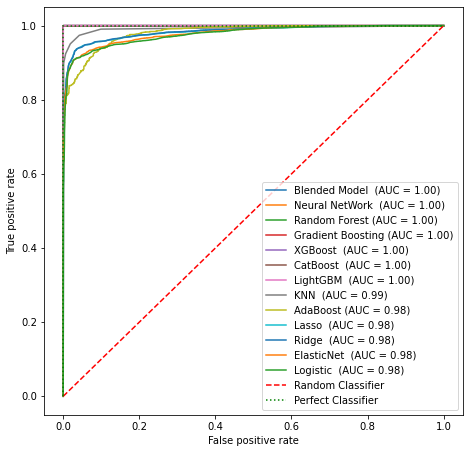

In [52]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

y_hat_blended_probs=((0.5 * CBC_classifier.predict_proba(test_X_ord)) + \
                (0.3 * XGB_classifier.predict_proba(test_X_ord)) + \
                (0.1 * RF_classifier.predict_proba(test_X_ord)) + \
                (0.1 * GBM_classifier.predict_proba(test_X_ord)) )

fpr1, tpr1, thresholds = roc_curve(test_y_ord, y_hat_RF_probs[:, 1], pos_label=1)
fpr2, tpr2, thresholds = roc_curve(test_y_ord, y_hat_AdB_probs[:, 1], pos_label=1)
fpr3, tpr3, thresholds = roc_curve(test_y_ord, y_hat_GBM_probs[:, 1], pos_label=1)
fpr4, tpr4, thresholds = roc_curve(test_y_ord, y_hat_XGB_probs[:, 1], pos_label=1)
fpr5, tpr5, thresholds = roc_curve(test_y_ord, y_hat_CBC_probs[:, 1], pos_label=1)
fpr6, tpr6, thresholds = roc_curve(test_yd, yd_hat_Logistic_probs[:, 1], pos_label=1)
fpr7, tpr7, thresholds = roc_curve(test_yd, yd_hat_Lasso_probs[:, 1], pos_label=1)
fpr8, tpr8, thresholds = roc_curve(test_yd, yd_hat_Ridge_probs[:, 1], pos_label=1)
fpr9, tpr9, thresholds = roc_curve(test_yd, yd_hat_ElasticNet_probs[:, 1], pos_label=1)
fpr10, tpr10, thresholds = roc_curve(test_yd, yd_hat_KNN_probs[:, 1], pos_label=1)
fpr11, tpr11, thresholds = roc_curve(test_yd, yd_hat_Neural_probs, pos_label=1)
fpr12, tpr12, thresholds = roc_curve(test_y_ord, y_hat_LGB_probs[:, 1], pos_label=1)
fpr13, tpr13, thresholds = roc_curve(test_y_ord, y_hat_blended_probs[:, 1], pos_label=1)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)
roc_auc9 = auc(fpr9, tpr9)
roc_auc10 = auc(fpr10, tpr10)
roc_auc11 = auc(fpr11, tpr11)
roc_auc12 = auc(fpr12, tpr12)
roc_auc13 = auc(fpr13, tpr13)

# auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

plt.plot(fpr13, tpr13, label='Blended Model  (AUC = %0.2f)' % (roc_auc13))
plt.plot(fpr11, tpr11, label='Neural NetWork  (AUC = %0.2f)' % (roc_auc11))
plt.plot(fpr1, tpr1, label='Random Forest (AUC = %0.2f)' % (roc_auc1))
plt.plot(fpr3, tpr3, label='Gradient Boosting (AUC = %0.2f)' % (roc_auc3))
plt.plot(fpr4, tpr4, label='XGBoost  (AUC = %0.2f)' % (roc_auc4))
plt.plot(fpr5, tpr5, label='CatBoost  (AUC = %0.2f)' % (roc_auc5))
plt.plot(fpr12, tpr12, label='LightGBM  (AUC = %0.2f)' % (roc_auc12))
plt.plot(fpr10, tpr10, label='KNN  (AUC = %0.2f)' % (roc_auc10))
plt.plot(fpr2, tpr2, label='AdaBoost (AUC = %0.2f)' % (roc_auc2))
plt.plot(fpr7, tpr7, label='Lasso  (AUC = %0.2f)' % (roc_auc7))
plt.plot(fpr8, tpr8, label='Ridge  (AUC = %0.2f)' % (roc_auc8))
plt.plot(fpr9, tpr9, label='ElasticNet  (AUC = %0.2f)' % (roc_auc9))
plt.plot(fpr6, tpr6, label='Logistic  (AUC = %0.2f)' % (roc_auc6))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

In [31]:
Logistic_importance[0,:].shape

(473,)

In [32]:
FIM = pd.DataFrame({'Features': train_X_ord.columns 
                   , 'CBC_Feature_importance':CBC_importance
                   , 'GBM_Feature_importance':GBM_importance
                   , 'XGB_Feature_importance':XGB_importance
                   , 'RF_Feature_importance':RF_importance
                   , 'LGB_Feature_importance':LGB_importance
                   , 'AdB_Feature_importance':AdB_importance
                   , 'Logistic_Feature_importance':Logistic_importance[0,:]
                   , 'Ridge_Feature_importance':Ridge_importance[0,:]
                   , 'Lasso_Feature_importance':Lasso_importance[0,:]
                   , 'ElasticNet_Feature_importance':ElasticNet_importance[0,:]})
FIM = FIM.sort_values(by=['AdB_Feature_importance'], ascending=False )
display(FIM[['Features',
             'AdB_Feature_importance',
             'Logistic_Feature_importance',
             'ElasticNet_Feature_importance',
             'CBC_Feature_importance']].head(50))

,Features,AdB_Feature_importance,Logistic_Feature_importance,ElasticNet_Feature_importance,CBC_Feature_importance
469,Category_Inpatient,0.12,0.160919,0.137369,15.767728
75,PatientCountsByProviders,0.06,0.472719,0.444131,2.094391
147,Age_group_35-45,0.06,0.432872,0.360395,1.349534
78,ClaimCountsByProviders,0.04,-0.003865,-0.009958,2.051777
19,ChronicCond_stroke,0.04,0.189861,0.115502,2.428604
472,IsDead_Yes,0.02,-0.594622,-0.398209,0.330128
330,County_750,0.02,-0.217543,-0.194846,0.724784
209,County_280,0.02,-0.318512,-0.294541,0.640173
192,County_210,0.02,0.300632,0.203524,0.172597
187,County_180,0.02,0.078902,-0.042659,0.338200


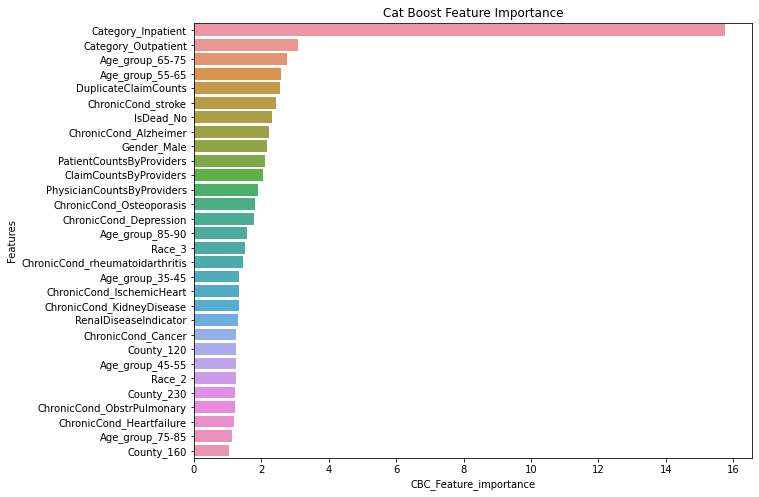

In [34]:
plt.figure(figsize=(10,8))
plt.title('Cat Boost Feature Importance')
FIM = FIM.sort_values(by=['CBC_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='CBC_Feature_importance', data=FIM.head(30))
plt.show()

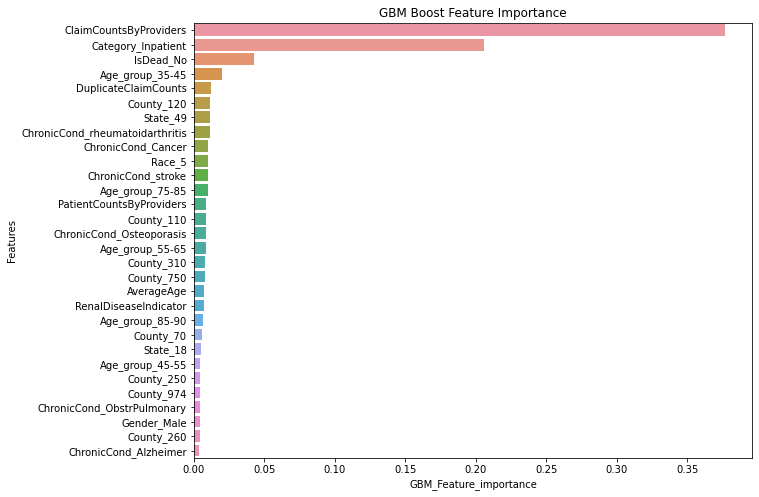

In [53]:
plt.figure(figsize=(10,8))
plt.title('GBM Boost Feature Importance')
FIM = FIM.sort_values(by=['GBM_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='GBM_Feature_importance', data=FIM.head(30))
plt.show()

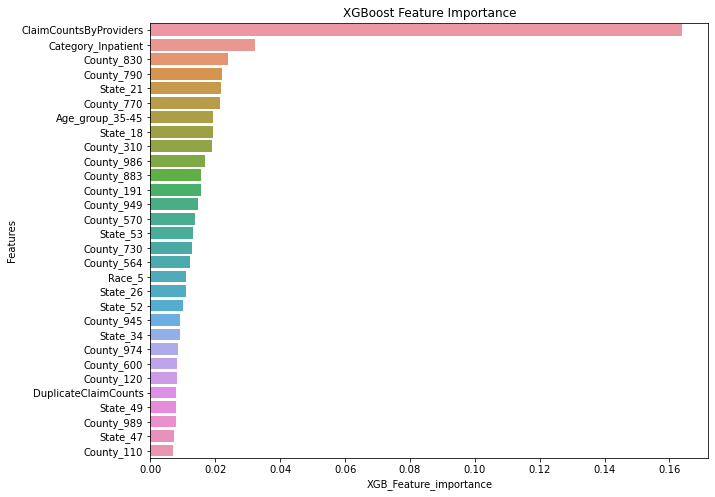

In [35]:
plt.figure(figsize=(10,8))
plt.title('XGBoost Feature Importance')
FIM = FIM.sort_values(by=['XGB_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='XGB_Feature_importance', data=FIM.head(30))
plt.show()

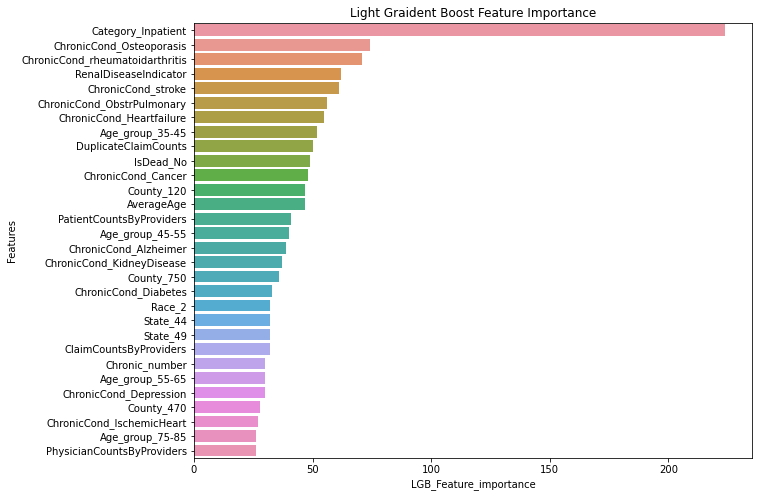

In [36]:
plt.figure(figsize=(10,8))
plt.title('Light Graident Boost Feature Importance')
FIM = FIM.sort_values(by=['LGB_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='LGB_Feature_importance', data=FIM.head(30))
plt.show()

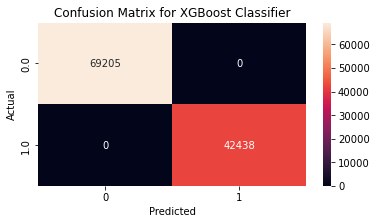

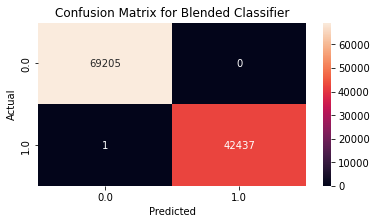

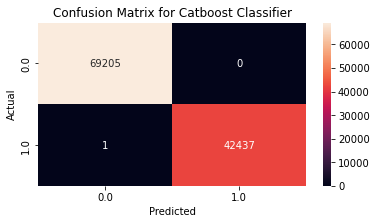

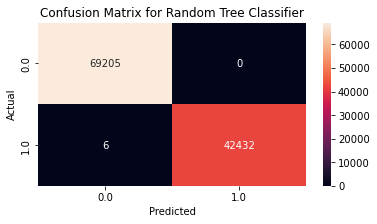

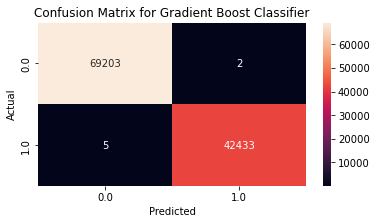

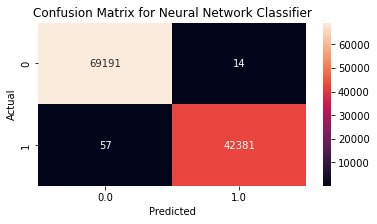

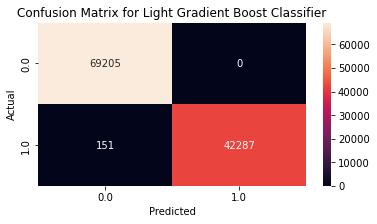

In [56]:
def confusionmatrix(y_actual, y_pred, modellabel=''):
    df=pd.DataFrame()
    df['Actual']=y_actual
    df['Predicted']=y_pred

    confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.title('Confusion Matrix for ' +modellabel+' Classifier')
    plt.show()
    
y_hat_blended=np.round(blended_predict('test'))
confusionmatrix(test_y_ord, y_hat_XGB, modellabel='XGBoost')
confusionmatrix(test_y_ord, y_hat_blended, modellabel='Blended')
confusionmatrix(test_y_ord, y_hat_CBC, modellabel='Catboost')
confusionmatrix(test_y_ord, y_hat_RF, modellabel='Random Tree')
confusionmatrix(test_y_ord, y_hat_GBM, modellabel='Gradient Boost')
confusionmatrix(test_yd, yd_hat_Neural, modellabel='Neural Network')
confusionmatrix(test_y_ord, y_hat_LGB, modellabel='Light Gradient Boost')